In [1]:
import pandas as pd
import geopandas as gpd
import s3fs
import pyarrow
import contextily as cx

In [2]:
df = gpd.read_parquet(
    "s3://weave.energy/smart-meter", 
    filters=[("data_collection_log_timestamp", "==", pd.Timestamp("2024-07-14T20:00:00Z"))])

df.head()


,dataset_id,dno_alias,aggregated_device_count_active,total_consumption_active_import,data_collection_log_timestamp,geometry,secondary_substation_unique_id,lv_feeder_unique_id
0,NGED_110191_11_Jul_2024,NGED,26.0,7693.0,2024-07-14 20:00:00+00:00,POINT (-2.5715 51.4262),NGED-110191,NGED-110191-11
1,NGED_110191_21_Jul_2024,NGED,28.0,4135.0,2024-07-14 20:00:00+00:00,POINT (-2.5715 51.4262),NGED-110191,NGED-110191-21
2,NGED_110191_22_Jul_2024,NGED,11.0,1920.0,2024-07-14 20:00:00+00:00,POINT (-2.5715 51.4262),NGED-110191,NGED-110191-22
3,NGED_110191_31_Jul_2024,NGED,23.0,4547.0,2024-07-14 20:00:00+00:00,POINT (-2.5715 51.4262),NGED-110191,NGED-110191-31
4,NGED_110191_42_Jul_2024,NGED,24.0,3412.0,2024-07-14 20:00:00+00:00,POINT (-2.5715 51.4262),NGED-110191,NGED-110191-42


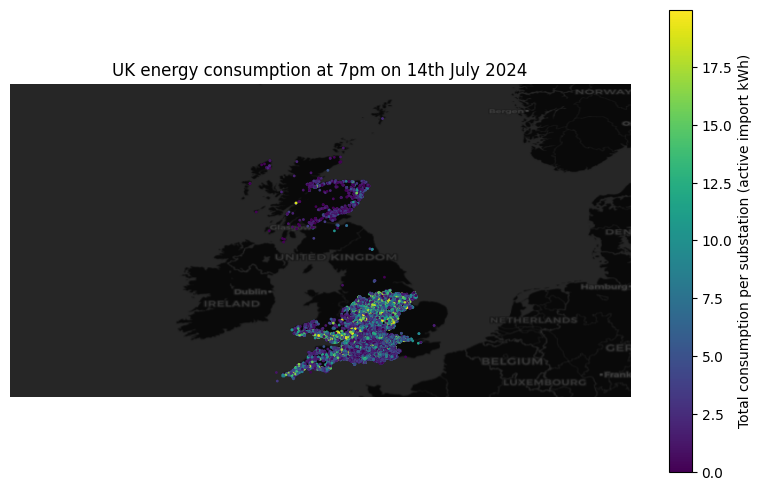

In [ ]:
substations = df.groupby(["secondary_substation_unique_id", "geometry"], as_index=False).sum("total_consumption_active_import").set_geometry("geometry")
# There are still issues with extreme outliers, so we filter them out
substations = substations[substations["total_consumption_active_import"] < 20000]

# Turn Wh consumption into kWh
substations["total_consumption_active_import"] /= 1000


ax = substations.plot(kind="geo", column="total_consumption_active_import", markersize=1, legend=True, legend_kwds={"label": "Total consumption per substation (active import kWh)"}, figsize=(10, 6))
ax.set_title("UK energy consumption at 7pm on 14th July 2024")
ax.set_axis_off()
ax.set_xlim(-18, 10)
ax.set_ylim(49.25, 61.5)
cx.add_basemap(ax, crs=4326, source=cx.providers.CartoDB.DarkMatter, attribution=False)
